# Analysis of the correlation between earthquakes and surface mass loading
This version is different from other calculations that we've done insofar as it performs the calculation in Bayes Theorem *regionally*, i.e., in each GRACE mascon. These results are then stacked to form a global posterior distribution.

In [1]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# from global_land_mask import globe
import scipy.stats as stats
import os
import importlib
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.style.use('fivethirtyeight')
import matplotlib.cm as cm
import numpy.ma as ma
from tqdm import tqdm
from shapely.geometry import Point, Polygon

# file containing functions:
import loadquakes
importlib.reload(loadquakes)

<module 'loadquakes' from '/home/bradlipovsky/notebooks/SLIQ/loadquakes.py'>

## 1. Load datasets

- GRACE and GRACE-FO
- USGS earthquake catalog with ETAS probabilities

In [2]:
# GRACE data
# basepath = '/'
basepath='/data/fast1/surface-load/'
ds = xr.open_dataset(basepath+"GRCTellus.JPL.200204_202201.GLO.RL06M.MSCNv02CRI.nc")

# Catalog of events from 2002-04-16 to 2022-1-16 with magnitude >= 5.4
catalog = pd.read_csv('catalog.csv')
etas_declustered = pd.read_csv('etas_declustered.csv')

### 2.1 Analyze the full catalog (n=12573), by mascon
Here, we calculate P(L|E) and P(L) within each mascon (from the JPL mascon placement file)

In [3]:
'''
Calculates conditional probability P(E|L) using loads during earthquakes P(L|E) and loads during all time periods P(L)
'''

def get_cp(LgE, L):
    cp_list = []  
    
    bins = np.linspace(-80,80,80)

    LgE_hist = np.histogram(LgE, bins=bins, density=True)[0] 
    L_hist = np.histogram(L, bins=bins, density=True)[0]

    cp = np.divide(LgE_hist, L_hist, out=np.zeros_like(LgE_hist), where=L_hist != 0)

    return bins, cp  #  list of cps for all mascons that contain earthquakes

In [4]:
mascon = xr.open_dataset('JPL_MSCNv03_PLACEMENT.nc')
mascon_center_lat = mascon['mascon_lat'].data
mascon_center_lon = mascon['mascon_lon'].data
mascon_id = mascon['mascon_id'].data

lwe_data = ds.lwe_thickness
cap_radius_deg = 1.5  # Spherical cap radius in degrees

In [5]:
'''
Full catalog - Convert earthquake data to a GeoDataFrame
'''
# Convert longitude and latitude coordinates to Shapely Point objects for spatial operations
geometry_full = [Point(xy) for xy in zip(catalog['longitude'], catalog['latitude'])]

# Create a GeoDataFrame with the full earthquake catalog
catalog_gdf_full = gpd.GeoDataFrame(catalog, geometry=geometry_full, crs="EPSG:4326")  
# EPSG:4326 specifies the coordinate reference system (WGS 84)

# Create a spatial index for fast spatial queries (used for spatial joins)
catalog_gdf_full.sindex  # Improves efficiency when searching for earthquakes within regions


'''
ETAS Declustered Catalog - Convert ETAS declustered earthquake data to a GeoDataFrame
'''
# Convert ETAS declustered catalog's coordinates into Shapely Point objects for spatial analysis
geometry_etas = [Point(xy) for xy in zip(etas_declustered['longitude'], etas_declustered['latitude'])]

# Create a GeoDataFrame specifically for the ETAS declustered catalog
catalog_gdf_etas = gpd.GeoDataFrame(etas_declustered, geometry=geometry_etas, crs="EPSG:4326")

# Create a spatial index for fast spatial queries in the ETAS declustered dataset
catalog_gdf_etas.sindex  # This allows quick lookups for earthquake locations


In [20]:
def calc_cp_by_mascon(catalog_gdf, loads):
    """
    Calculates conditional probability P(E|L) in every mascon using each mascon's center coordinates 
    and creating a 1.5-degree radius spherical cap around each one.
    
    Parameters:
    - catalog_gdf (GeoDataFrame): A GeoDataFrame containing earthquake data with spatial geometry.
    - loads (xarray DataArray): GRACE-derived surface load dataset.

    Returns:
    - cp_averaged (numpy array): Averaged conditional probabilities P(E|L) across all mascons.
    - bins (numpy array): Bin edges used for probability computation.
    """
    
    cp = []  # List to store conditional probabilities for each mascon

    # Iterate through each mascon center
    # tqdm can be used for progress tracking if needed
    for i in range(len(mascon_id)):
        # Create a Shapely Point object for the mascon center
        center_point = Point(mascon_center_lon[i], mascon_center_lat[i])

        # Define a circular buffer (spherical cap) with a 1.5-degree radius
        bbox = center_point.buffer(cap_radius_deg)

        # Convert the buffer to a GeoDataFrame for spatial operations
        bbox_gdf = gpd.GeoDataFrame([1], geometry=[bbox], crs="EPSG:4326")

        # Perform a spatial join to find earthquakes located within the spherical cap
        these_earthquakes = gpd.sjoin(catalog_gdf, bbox_gdf, how='inner', predicate='within')

        # If no earthquakes are found within this cap, move to the next mascon
        if these_earthquakes.empty:
            continue

        # Retrieve surface load data for this mascon at its center coordinates
        L = loads.sel(lat=mascon_center_lat[i], lon=mascon_center_lon[i], method="nearest").data.flatten()

        # Extract load values at the times of earthquakes occurring in this mascon
        LgE = these_earthquakes.dmass  # Load at earthquake times

        # Number of earthquakes in this mascon (used as probability weight)
        E = len(these_earthquakes)  

        # Compute conditional probability P(E|L) for this mascon
        bins, this_cp = get_cp(LgE, L)
        this_cp = this_cp * E  # Weight by earthquake probability

        cp.append(this_cp)  # Store computed P(E|L)

    # Compute the average conditional probability across all mascons
    cp_averaged = np.nanmean(np.array(cp), axis=0)

    # Normalize the averaged conditional probability to sum to 1
    cp_averaged = cp_averaged / np.sum(cp_averaged)
    
    return cp_averaged, bins

In [21]:
cp_averaged, bins = calc_cp_by_mascon(catalog_gdf_full, lwe_data)

### 2.2 Repeat the analysis for the declustered catalog (n=537)

In [22]:
etas_cp_averaged, bins = calc_cp_by_mascon(catalog_gdf_etas, lwe_data)

### 2.3 Visualize results

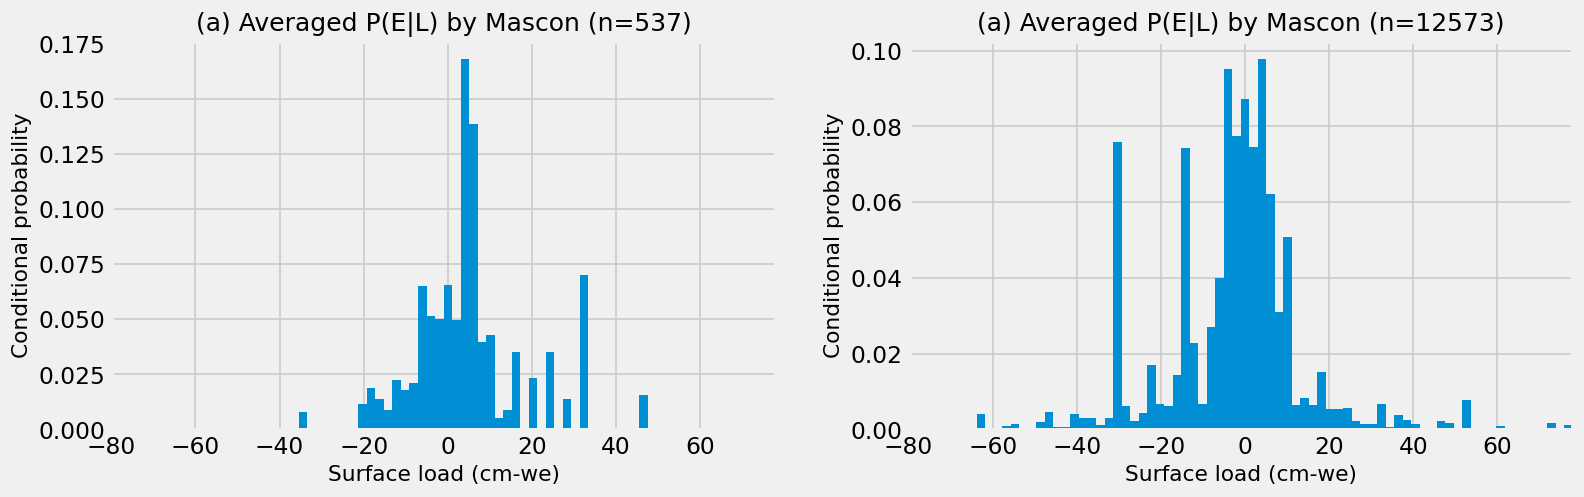

In [23]:
fig, axes = plt.subplots(1,2, figsize=(14, 4), dpi=120)
fs = 13

### (a) P(E|L) by Mascon (ETAS)
wid_etas = np.mean(np.diff(bins))

axes[0].bar(bins[:-1], etas_cp_averaged, width=wid_etas, align='edge')
axes[0].set_xlim(bins[0], bins[-2])
axes[0].set_xlabel('Surface load (cm-we)', fontsize=fs)
axes[0].set_ylabel('Conditional probability', fontsize=fs)
axes[0].set_title('(a) Averaged P(E|L) by Mascon (n=537)', fontsize=fs + 2)
axes[0].grid(True)

### (b) P(E|L) by Mascon (full catalog)
axes[1].bar(bins[:-1], cp_averaged / np.sum(cp_averaged), 
       width=wid_etas, align='edge')

axes[1].set_xlim(bins[0], bins[-2])
axes[1].set_xlabel('Surface load (cm-we)', fontsize=fs)
axes[1].set_ylabel('Conditional probability', fontsize=fs)
axes[1].set_title('(a) Averaged P(E|L) by Mascon (n=12573)', fontsize=fs + 2)
axes[1].grid(True)

## 3.1 Permutation testing

### The code below does the following:
1. Scramble loads (ds.lwe_thickness) and generate randomized data
2. Calculate cp for each randomized load dataset

In [84]:
# Number of randomizations
N = 1000

In [85]:
import multiprocessing as mp

def permute_and_compute(i, ds, catalog_gdf_full):
    """Function to shuffle the surface loads and recalculate P(E|L)."""
    # Extract and flatten the full surface load dataset
    all_grace_data = np.array(ds['lwe_thickness'].values)
    flat_grace = all_grace_data.ravel()

    # Shuffle and reshape
    np.random.shuffle(flat_grace)
    shuffled_grace = flat_grace.reshape(all_grace_data.shape)

    # Create a deep copy of the dataset
    ds_shuffled = ds.copy(deep=True)
    ds_shuffled['lwe_thickness'].values = shuffled_grace

    # Recalculate conditional probability P(E|L)
    cp_shuffled, bins = calc_cp_by_mascon(catalog_gdf_full, ds_shuffled['lwe_thickness'])

    return cp_shuffled

def run_permutation_test(N, ds, catalog_gdf_full):
    """Runs the permutation test using multiprocessing."""
    cp_real_distribution = []

    # Set up multiprocessing pool
    with mp.Pool(processes=mp.cpu_count()//2) as pool:
        results = list(tqdm(pool.starmap(permute_and_compute, [(i, ds, catalog_gdf_full) for i in range(N)]), total=N))

    cp_real_distribution.extend(results)

    return cp_real_distribution

In [86]:
cp_real_distribution = run_permutation_test(N, ds, catalog_gdf_full)
cp_real_distribution = np.array(cp_real_distribution)  # Shape: (N, num_bins)

100%|██████████| 1000/1000 [00:00<00:00, 2628010.03it/s]


## 3.2  Repeating analysis for ETAS declustered catalog

In [87]:
etas_cp_real_distribution = run_permutation_test(N, ds, catalog_gdf_etas)
etas_cp_real_distribution = np.array(etas_cp_real_distribution)  # Shape: (N, num_bins)

100%|██████████| 1000/1000 [00:00<00:00, 2664742.06it/s]


## 4. Figures

### 4.1 Convergence test

N: 79
95 percentile: 0.06991661971619795
99 percentile: 0.088944746904146
 
N: 790
95 percentile: 0.06991661971619795
99 percentile: 0.088944746904146
 
N: 3950
95 percentile: 0.06991661971619795
99 percentile: 0.088944746904146
 
N: 7900
95 percentile: 0.06991661971619795
99 percentile: 0.088944746904146
 


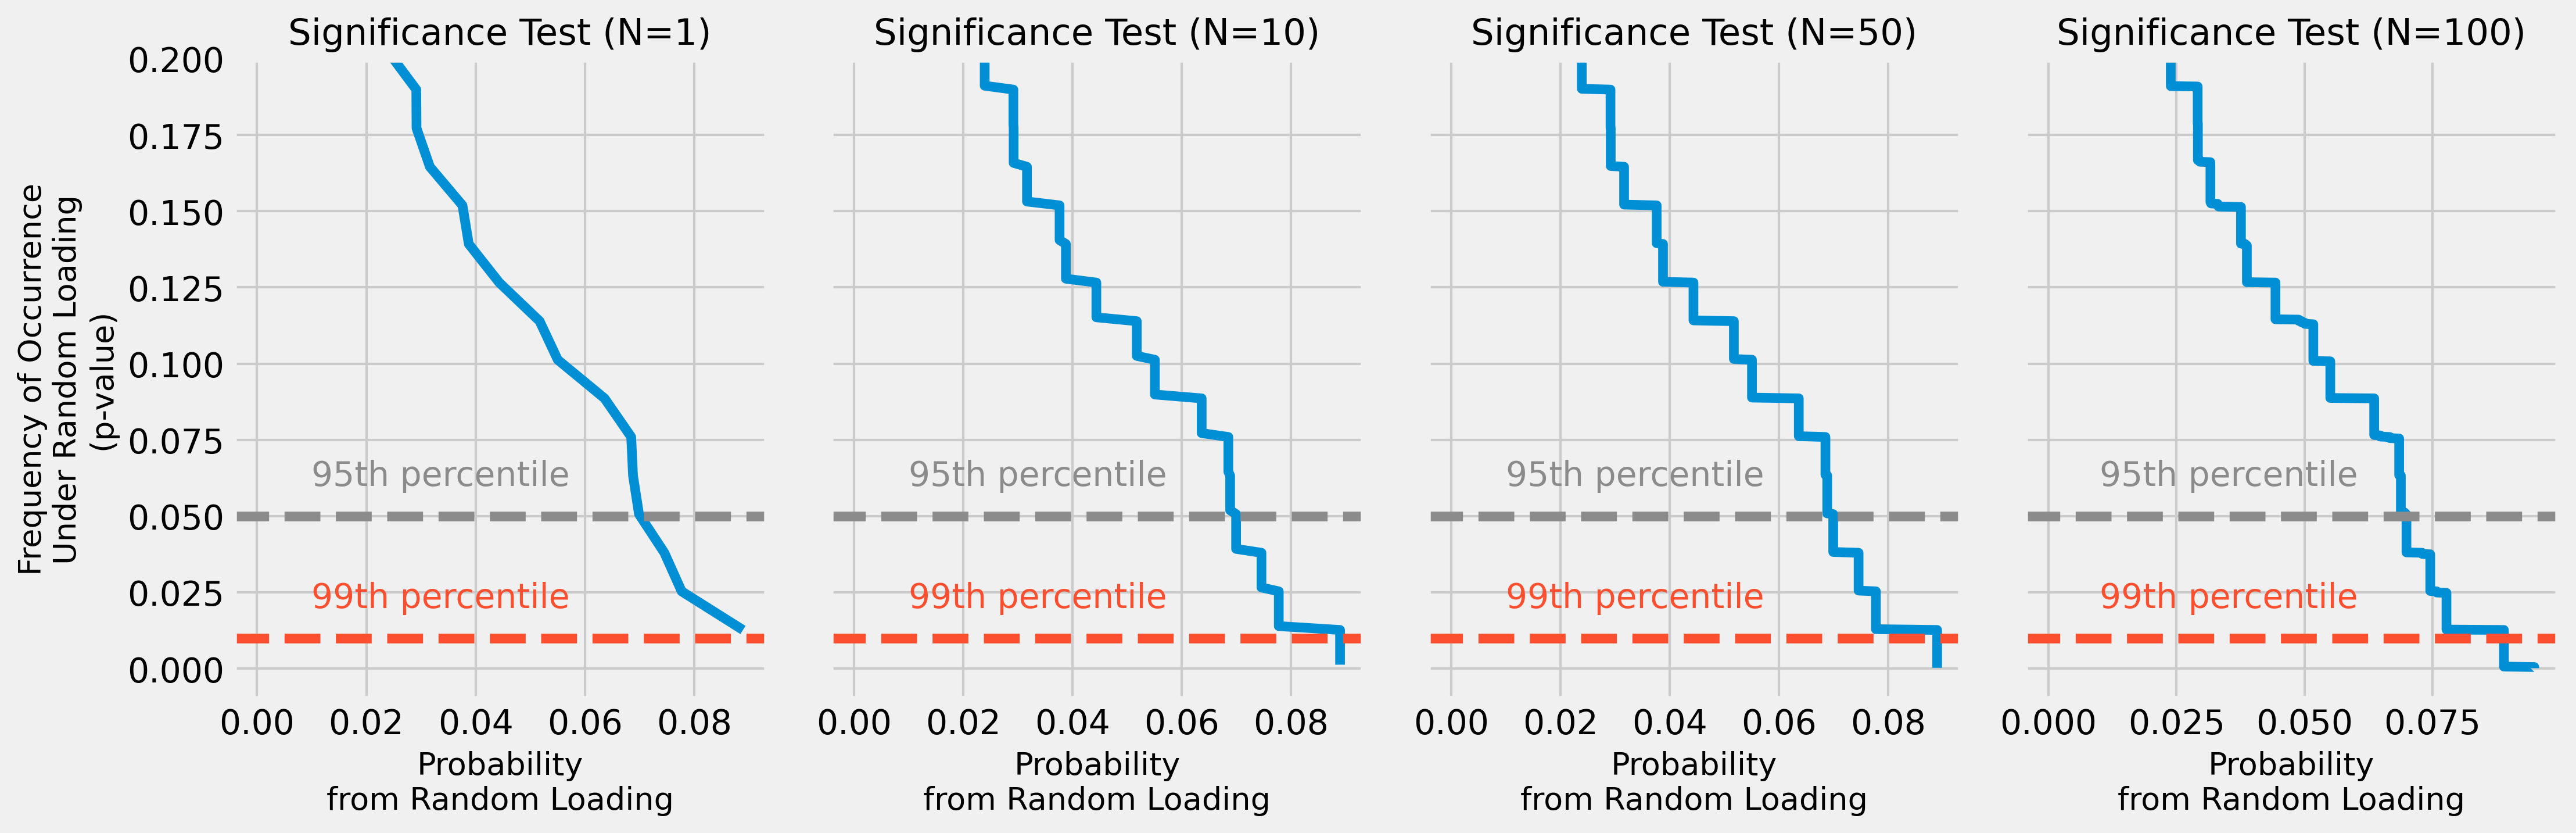

In [37]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5), dpi=300, sharey=True)
fs = 13

# Define different data slices for each subplot
partial_rds = [
    cp_real_distribution[0, :],
    cp_real_distribution[0:10, :].flatten(),
    cp_real_distribution[0:50, :].flatten(),
    cp_real_distribution[0:100, :].flatten(),
]

titles = [
    "Significance Test (N=1)",
    "Significance Test (N=10)",
    "Significance Test (N=50)",
    "Significance Test (N=100)",
]

# Plot each dataset in the 1x4 figure
for i, (ax, partial_rd, title) in enumerate(zip(axes, partial_rds, titles)):
    print(f"N: {len(partial_rd)}")

    sorted_data = np.sort(partial_rd)
    pval = 1 - np.arange(sorted_data.size) / sorted_data.size
    

    print(f'95 percentile: {sorted_data[np.argmin(np.abs(pval - 0.05))]}')
    print(f'99 percentile: {sorted_data[np.argmin(np.abs(pval - 0.01))]}')
    print(' ')

    ax.plot(sorted_data, pval)
    ax.set_xlabel("Probability\nfrom Random Loading", fontsize=fs)
    ax.set_title(title, fontsize=fs + 2)
    ax.set_ylim([-0.01, 0.2])
    ax.text(0.01, 0.02, '99th percentile', color='C1')
    ax.text(0.01, 0.06, '95th percentile', color='C4')
    ax.axhline(y=0.01, color="C1", linestyle="--", label="99th percentile")
    ax.axhline(y=0.05, color="C4", linestyle="--", label="95th percentile")

    if i == 0:  # Add ylabel only to the first subplot for clarity
        ax.set_ylabel("Frequency of Occurrence\nUnder Random Loading\n(p-value)", fontsize=fs)
    
    ax.grid(True)

# Layout adjustment
plt.tight_layout()
plt.show()


### 4.2 Significance test & conditional probabilities

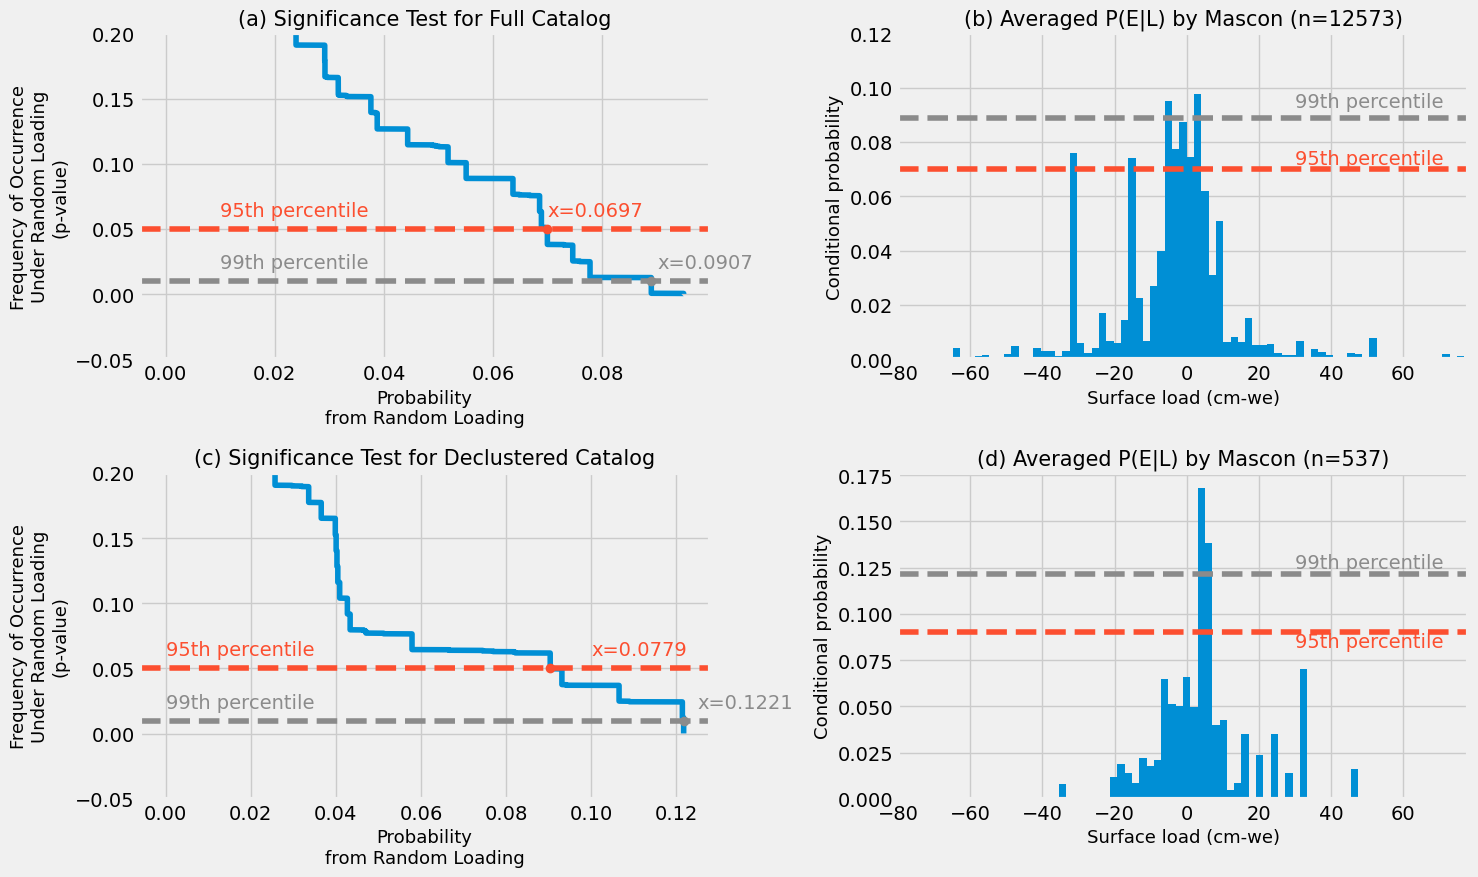

In [38]:
plt.style.use('fivethirtyeight')
fig, axes = plt.subplots(2, 2, figsize=(15, 9))
fs = 13

### (1) Significance Test for Full Catalog
ax = axes[0, 0]
wid_etas = np.mean(np.diff(bins))
full_dist = cp_real_distribution.flatten()
sorted_data = np.sort(full_dist)
pval = 1 - np.arange(sorted_data.size) / sorted_data.size
ax.plot(sorted_data, pval)
ax.set_ylabel('Frequency of Occurrence\nUnder Random Loading\n(p-value)', fontsize=fs)
ax.set_xlabel('Probability\nfrom Random Loading', fontsize=fs)
ax.set_title('(a) Significance Test for Full Catalog', fontsize=fs + 2)
ax.set_ylim([-0.05, 0.2])
significant95 = min(sorted_data[pval < 0.05])
significant99 = min(sorted_data[pval < 0.01])

ax.text(0.01, 0.06, '95th percentile', color='C1')
ax.axhline(y=0.05, color='C1', linestyle='--')
ax.plot(significant95, 0.05, 'C1o')
ax.text(0.07, 0.06, 'x=0.0697', color='C1')

ax.text(0.01, 0.02, '99th percentile', color='C4')
ax.axhline(y=0.01, color='C4', linestyle='--')
ax.plot(significant99, 0.01, 'C4o')
ax.text(0.09, 0.02, 'x=0.0907', color='C4')

ax.grid(True)

### (2) P(E|L) by Mascon (Full Catalog)
ax = axes[0, 1]
wid_etas = np.mean(np.diff(bins))
ax.bar(bins[:-1], cp_averaged / np.sum(cp_averaged), width=wid_etas)
ax.set_xlim(bins[0], bins[-2])
ax.set_xlabel('Surface load (cm-we)', fontsize=fs)
ax.set_ylabel('Conditional probability', fontsize=fs)
ax.set_title('(b) Averaged P(E|L) by Mascon (n=12573)', fontsize=fs + 2)
ax.text(30, 0.072, '95th percentile', color='C1')
ax.axhline(y=significant95, color='C1', linestyle='--')
ax.text(30, 0.093, '99th percentile', color='C4')
ax.axhline(y=significant99, color='C4', linestyle='--')
ax.grid(True)
ax.set_ylim([0, 0.12])

### (3) Significance Test for ETAS Declustered Catalog
ax = axes[1, 0]
wid_etas = np.mean(np.diff(bins))
full_dist = etas_cp_real_distribution.flatten()
sorted_data = np.sort(full_dist)
pval = 1 - np.arange(sorted_data.size) / sorted_data.size
ax.plot(sorted_data, pval)
ax.set_ylabel('Frequency of Occurrence\nUnder Random Loading\n(p-value)', fontsize=fs)
ax.set_xlabel('Probability\nfrom Random Loading', fontsize=fs)
ax.set_title('(c) Significance Test for Declustered Catalog', fontsize=fs + 2)
ax.set_ylim([-0.05, 0.2])
significant95 = min(sorted_data[pval < 0.05])
significant99 = min(sorted_data[pval < 0.01])
ax.text(0, 0.06, '95th percentile', color='C1')
ax.axhline(y=0.05, color='C1', linestyle='--')
ax.plot(significant95, 0.05, 'C1o')
ax.text(0.1, 0.06, 'x=0.0779', color='C1')
ax.text(0, 0.02, '99th percentile', color='C4')
ax.axhline(y=0.01, color='C4', linestyle='--')
ax.plot(significant99, 0.01, 'C4o')
ax.text(0.125, 0.02, 'x=0.1221', color='C4')
ax.grid(True)

### (4) P(E|L) by Mascon (Declustered Catalog)
ax = axes[1, 1]
wid_etas = np.mean(np.diff(bins))
norm_cp_etas = etas_cp_averaged / np.sum(etas_cp_averaged)
ax.bar(bins[:-1], norm_cp_etas, width=wid_etas, align='edge')
ax.set_xlim(bins[0], bins[-2])
ax.set_xlabel('Surface load (cm-we)', fontsize=fs)
ax.set_ylabel('Conditional probability', fontsize=fs)
ax.set_title('(d) Averaged P(E|L) by Mascon (n=537)', fontsize=fs + 2)
ax.text(30, 0.082, '95th percentile', color='C1')
ax.axhline(y=significant95, color='C1', linestyle='--')
ax.text(30, 0.125, '99th percentile', color='C4')
ax.axhline(y=significant99, color='C4', linestyle='--')

# ax.axvline(sig_bins_left[0], color='C5')
# ax.axvline(sig_bins_right[1], color='C3')
ax.grid(True)

# Layout adjustment
plt.tight_layout()
plt.show()


### 5. Excess Probability Calculation

Our max conditional probability is ~0.17 and the significance level is ~0.12.  So how many "excess events" were there?

In [144]:
excess_event_fraction = (norm_cp_etas - significant99) / norm_cp_etas
excess_event_fraction = excess_event_fraction[excess_event_fraction>0]
excess_event_fraction # In the two bins that are significant

/tmp/ipykernel_229790/3587691867.py:1: RuntimeWarning: divide by zero encountered in divide
  excess_event_fraction = (norm_cp_etas - significant99) / norm_cp_etas


array([0.27473521, 0.12139155])